In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!nvidia-smi

Sun Mar 30 04:23:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install -q transformers
!pip install -q sentencepiece

In [3]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile

import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def read_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return image

In [6]:
def ocr(image, processor, model):
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [7]:
def eval_new_data(data_path=None, num_samples=4, model=None):
  image_paths = glob.glob(data_path)
  for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):

    if i == num_samples:
      break
    image = read_image(image_path)
    text = ocr(image, processor, model)
    plt.figure(figsize=(7, 4))
    plt.imshow(image)
    plt.title(text)
    plt.axis('off')
    plt.show()

In [8]:
from IPython.display import clear_output
clear_output()

In [9]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-base-handwritten'
).to(device)

clear_output()

In [10]:
eval_new_data(
    data_path="/content/demo4.jpg",
    num_samples=2,
    model=model
)

0it [00:00, ?it/s]

In [11]:
from torch.utils.data import Dataset, DataLoader

In [12]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Now Demo/Data/text_images.csv", header=None, names=['file_name', 'text'],usecols=[0,1],skiprows=1)
validation_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Now Demo/Data/text_images.csv", header=None, names=['file_name', 'text'],usecols=[0,1],skiprows=1)
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Now Demo/Testing/testing_labels.csv", header=None, names=['file_name', 'text'],usecols=[0,1],skiprows=1)

In [13]:
train_df.head()

,file_name,text
0,0.jpg,quirky
1,1.jpg,"lake ,"
2,2.jpg,a
3,3.jpg,moon .
4,4.jpg,fox


In [138]:
import numpy as np
import cv2

In [139]:
def preprocess_image(image):
  image = np.array(image)

  if len(image.shape) == 2:
      # Check if image is grayscale
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)

  # Unsharp Masking: Enhance Edges
  sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
  binary = cv2.adaptiveThreshold(sharpened, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)
  binary = cv2.bitwise_not(binary)
  kernel = np.ones((2, 2), np.uint8)
  denoised = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
  denoised = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)
  edges = cv2.Canny(denoised, 50, 150)
  final_image = cv2.resize(denoised, (384, 384), interpolation=cv2.INTER_AREA)
  if len(final_image.shape) == 2:
    final_image = cv2.cvtColor(final_image, cv2.COLOR_GRAY2RGB)  # Convert to RGB (3 dimensions)
  return final_image

In [116]:
# 1. Fixed Dataset Class
class OCRDataset(Dataset):
  def __init__(self, image_dir, df, processor, max_target_length=64):
    self.image_dir = image_dir
    self.processor = processor
    self.max_target_length = max_target_length
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_name = self.df.iloc[idx, 0]
    text = self.df.iloc[idx, 1]

    # Load image
    image_path = os.path.join(self.image_dir, img_name)
    try:
        image = Image.open(image_path).convert("RGB")
        processed_image = preprocess_image(image)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        raise

    # Process image and text separately
    pixel_values = self.processor.feature_extractor(
        processed_image,
        return_tensors="pt"
    ).pixel_values.squeeze(0)

    labels = self.processor.tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        max_length=self.max_target_length,
        truncation=True
    ).input_ids.squeeze(0)

    return {
        'pixel_values': pixel_values,
        'labels': labels              # Shape: [max_length]
    }

In [117]:
# 2. Data Collator
class TrOCRDataCollator:
  def __init__(self, processor):
    self.processor = processor


  def __call__(self, batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])

    # Create decoder inputs by shifting labels right
    decoder_input_ids = labels.clone()
    decoder_input_ids[:, 1:] = labels[:, :-1]
    decoder_input_ids[:, 0] = self.processor.tokenizer.cls_token_id

    return {
        "pixel_values": pixel_values,
        "labels": labels,
        "decoder_input_ids": decoder_input_ids,
        #"attention_mask": (decoder_input_ids != self.processor.tokenizer.pad_token_id).int()
    }

In [118]:
# Configure model
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

In [119]:
# 4. Create Datasets
train_dataset = OCRDataset(
    image_dir="/content/drive/MyDrive/Colab Notebooks/Now Demo/Data/Images",
    df=train_df,
    processor=processor
)

val_dataset = OCRDataset(
    image_dir="/content/drive/MyDrive/Colab Notebooks/Now Demo/Data/Images",
    df=validation_df,
    processor=processor
)

test_dataset = OCRDataset(
    image_dir="/content/drive/MyDrive/Colab Notebooks/Now Demo/Testing/testing_words",
    df=test_df,
    processor=processor
)

In [120]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments,DataCollatorForSeq2Seq

In [141]:
# 5. Training Configuration
training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-finetuned",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=50,
    learning_rate=2e-5,
    fp16=torch.cuda.is_available(),
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    predict_with_generate=True,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    weight_decay=0.01,
)


In [122]:
# 6. Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=TrOCRDataCollator(processor),
    tokenizer=processor,
)

<ipython-input-122-bc9d32b1c75e>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [123]:
print(train_dataset.df)

   file_name        text
0      0.jpg      quirky
1      1.jpg      lake ,
2      2.jpg           a
3      3.jpg      moon .
4      4.jpg         fox
5      5.jpg        lazy
6      6.jpg     through
7      7.jpg     glowing
8      8.jpg       dog .
9      9.jpg         The
10    10.jpg       dozen
11    11.jpg        Jack
12    12.jpg      jogged
13    13.jpg         and
14    14.jpg      broken
15    15.jpg        over
16    16.jpg       brown
17    17.jpg       While
18    18.jpg      amazed
19    19.jpg     quickly
20    20.jpg       lamps
21    21.jpg      zebras
22    22.jpg  zigzagging
23    23.jpg     streets
24    24.jpg      fixing
25    25.jpg       jumps
26    26.jpg        busy
27    27.jpg          by
28    28.jpg       words
29    29.jpg      Victor
30    30.jpg      danced
31    31.jpg         the
32    32.jpg        near
33    33.jpg       quick
34    34.jpg    everyone
35    35.jpg         the
36    36.jpg       under


In [124]:
# 7. Verify Data Loading
print("\nVerifying first training sample:")
sample = train_dataset[0]
print("Pixel values shape:", sample["pixel_values"].shape)
print("Labels shape:", sample["labels"].shape)

print("\nVerifying batch creation:")
sample_batch = trainer.data_collator([train_dataset[i] for i in range(2)])
print("Batch shapes:")
print({k: v.shape for k, v in sample_batch.items()})

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(



Verifying first training sample:
Pixel values shape: torch.Size([3, 384, 384])
Labels shape: torch.Size([64])

Verifying batch creation:
Batch shapes:
{'pixel_values': torch.Size([2, 3, 384, 384]), 'labels': torch.Size([2, 64]), 'decoder_input_ids': torch.Size([2, 64])}


In [125]:
# 8. Start Training
print("\nStarting training...")
trainer.train()




Starting training...


Step,Training Loss,Validation Loss


TrainOutput(global_step=30, training_loss=0.16739586194356282, metrics={'train_runtime': 44.0603, 'train_samples_per_second': 2.519, 'train_steps_per_second': 0.681, 'total_flos': 8.305965620055245e+16, 'train_loss': 0.16739586194356282, 'epoch': 3.0})

In [126]:
model_path = "/content/trocr-finetuned"

trainer.save_model()
processor.save_pretrained(model_path)

[]

In [127]:
processor = TrOCRProcessor.from_pretrained(model_path)
model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

  0%|          | 0/1 [00:00<?, ?it/s]

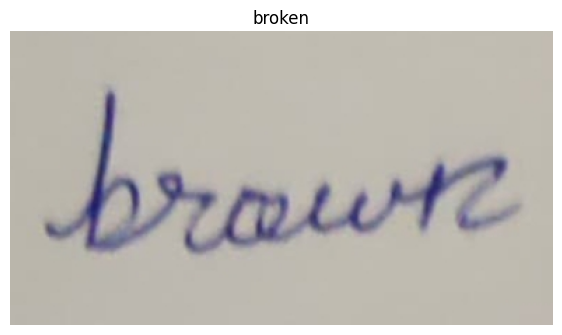

In [136]:
eval_new_data(
    data_path="/content/drive/MyDrive/Colab Notebooks/Now Demo/Data/Images/16.jpg",
    num_samples=2,
    model=model
)